In [9]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import langevin_cached_model as lcm
import pymc3 as pm

In [3]:
data = pd.read_csv('results/delta10-2/data2/data.csv')

In [5]:
# initial prior
# both D and A have mean 1 and std 10
alpha_A=0.01
beta_A=0.01
alpha_D=2.01
beta_D=1.01

In [7]:
# compile model for reuse
sm = lcm.LangevinIG()
sm.samples=100000

In [8]:
trace = sm.run(x=data,
                aD=alpha_D,
                bD=beta_D,
                aA=alpha_A,
                bA=beta_A,
                delta_t=0.01,
                N=10000)

Applied log-transform to D and added transformed D_log to model.
Applied log-transform to A and added transformed A_log to model.
 [-----------------100%-----------------] 100000 of 100000 complete in 214.0 sec

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x125cc0e10>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x126428160>]], dtype=object)

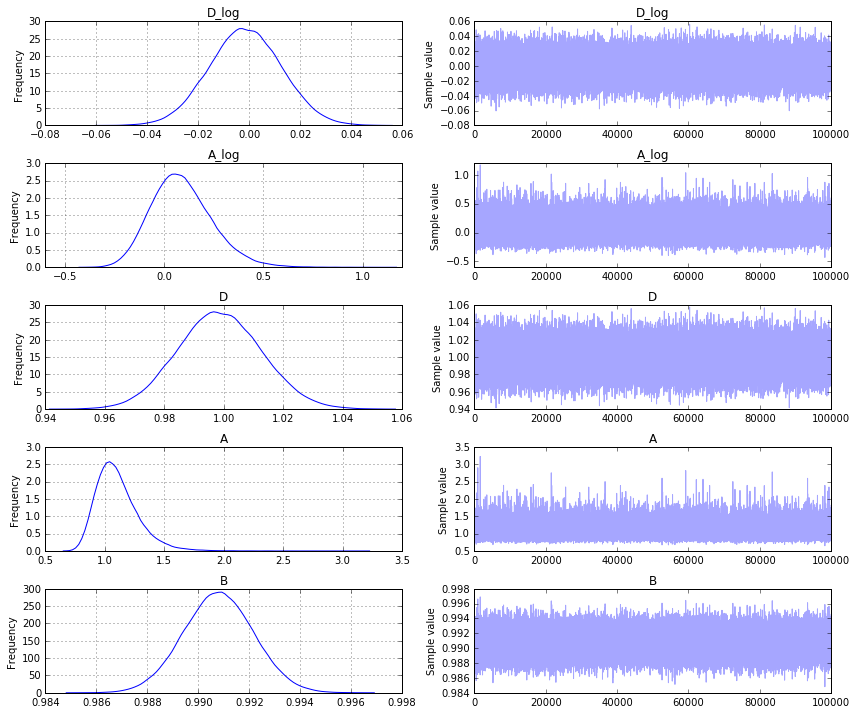

In [10]:
pm.traceplot(trace)

In [11]:
pm.summary(trace)


D_log:

  Mean             SD               MC Error         95% HPD interval
  -------------------------------------------------------------------
  
  -0.001           0.014            0.000            [-0.029, 0.026]

  Posterior quantiles:
  2.5            25             50             75             97.5
  |--------------|==============|==============|--------------|
  
  -0.029         -0.011         -0.002         0.008          0.026


A_log:

  Mean             SD               MC Error         95% HPD interval
  -------------------------------------------------------------------
  
  0.089            0.155            0.001            [-0.200, 0.397]

  Posterior quantiles:
  2.5            25             50             75             97.5
  |--------------|==============|==============|--------------|
  
  -0.179         -0.019         0.077          0.183          0.425


D:

  Mean             SD               MC Error         95% HPD interval
  ---------------------------

/Users/hstrey/anaconda/envs/python3/lib/python3.5/site-packages/numpy/core/fromnumeric.py:225: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  return reshape(newshape, order=order)
